In [1]:
import vaex as vx
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import scipy as sc
from scipy.interpolate import PchipInterpolator as minterp
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt
import ipyvolume as ipv
import plotly
import plotly.graph_objs as go
# Configure Plotly to be rendered inline in the notebook.

plotly.offline.init_notebook_mode(connected=True)

from tqdm import tqdm

import os
import sys
import re
import gc
from numba import jit
from collections import Counter
from collections import namedtuple
from collections import defaultdict

from sklearn.covariance import OAS
from sklearn.covariance import GraphicalLassoCV
from sklearn.covariance import LedoitWolf
from sklearn.covariance import EmpiricalCovariance

import tensorflow as tf

from umap import UMAP
from sklearn.manifold import MDS
from sklearn.decomposition import PCA, MiniBatchDictionaryLearning as DL, NMF, FastICA as ICA 
from sklearn.decomposition import FactorAnalysis as FA, SparsePCA as SPCA

from omic_helpers import omic_helpers as hlp


from xgboost import XGBClassifier as xgb
from lightgbm import LGBMClassifier as lgbm
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier as HB
from sklearn.ensemble import ExtraTreesClassifier as ET
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neural_network import MLPClassifier as mlpc
from sklearn.neural_network import MLPRegressor as mlpr
from sklearn.svm import SVC

from xgboost import XGBRegressor as xgbr
from lightgbm import LGBMRegressor as lgbmr
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, HuberRegressor, ARDRegression
from pygam import GAM, LinearGAM, ExpectileGAM, s, f, l, te
from ngboost import NGBRegressor as ngbr
from ngboost.distns import LogNormal, Normal,Bernoulli
from ngboost.learners import default_tree_learner
from ngboost.scores import MLE
from pyearth import Earth
from interpret.glassbox import ExplainableBoostingRegressor as ebr
from interpret import show as eb_show

from sklearn.inspection import permutation_importance, partial_dependence, plot_partial_dependence
from shap import TreeExplainer, force_plot, dependence_plot, summary_plot, KernelExplainer, LinearExplainer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score, average_precision_score
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import AffinityPropagation

from sklearn.feature_selection import mutual_info_classif as Minfo, f_classif as Fval, chi2


from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import cdist
from scipy.cluster import hierarchy

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/p

In [2]:
pre_filter = True # filter out weak univariates for classification
select_topN = 100
x_transform = None # MinMaxScaler, QuantileTransformer
x_reducer = None # PCA(n_components=10)
rem_coll = False

In [3]:
# Load gene list
genes = pd.read_csv('../../_meta_data/gene_types/selected_genes.csv', sep='\t')
genes.Symbol = genes.Symbol.str.upper()

In [4]:
os.chdir('/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/')

We start with RNA expression, methylation and DNA mutations separately.

The differentiation targets are the treatment response, the cancer types and the tissue type.

We use :

* statistical difference
* geometric difference
* multivariate classification

# Load data

In [5]:
# RNA 
# Methylation
# mutation
# Load meta data: immunoresponse, age, gender

dd = {}
dd['RNAex'] = vx.open('Lung_GeneExpression.hdf5')
dd['mutation'] = vx.open('Lung_Mutation.hdf5')
dd['methylation'] = vx.open('Lung_Methylation.hdf5')
dd['methylation_meta'] = vx.open('HumanMethylation450_meta.hdf5')
dd['CNV'] = vx.open('Lung_CNV.hdf5')

miRNA = pd.read_csv('Lung_miRNA.txt', sep="\t")
mimamap = miRNA[['MIMATID', 'Name', 'Chr', 'Start', 'Stop', 'Strand']]
miRNA.drop(['Name', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
miRNA = miRNA.set_index('MIMATID').transpose()

proteome = pd.read_csv("Lung_Proteome.txt", sep="\t")
proteome = proteome.set_index('sample').transpose()

meta = pd.read_csv('Lung_Phenotype_Metadata.txt', sep='\t')
meta = meta.loc[~pd.isna(meta.Diagnosis)]
meta = meta[~meta.SampleID.duplicated(keep='last')]
meta['SampleID']  = meta.SampleID.str.replace("\-", "_")
meta.set_index('SampleID', inplace=True)

In [6]:
granzyms = list(set(dd['RNAex'][dd['RNAex'].Gene.str.contains('(GZM)|(SECT)|(PRF)')].Gene.tolist()))
tmp = pd.DataFrame([{'Symbol':_int, 'gene_class': 'granzyms'} for _int in granzyms])
genes = pd.concat([genes, tmp])

In [7]:
interferons = list(set(dd['RNAex'][dd['RNAex'].Gene.str.contains('IFN')].Gene.tolist()))
tmp = pd.DataFrame([{'Symbol':_int, 'gene_class': 'interferon'} for _int in interferons])
genes = pd.concat([genes, tmp])

In [8]:
meta_cols = ['Gender', 'Diagnosis', 'Age At Diagnosis (Years)', 
             'Overall Survival Status', 'Pack Years', 'Smoking Status',
             'Time To Overall Survival (Days)']
meta_cols = meta_cols + ['New Tumor Event', 'Radiation Therapy', 'Reponse To Therapy', 'Drug Therapy Type']

stage_map = {'stage i': 1, 'stage ia': 1.33, 'stage ib': 1.66,
             'stage ii': 2, 'stage iia': 2.33, 'stage iib': 2.66,
             'stage iii': 3, 'stage iiia': 3.33, 'stage iiib': 3.66,
             'stage iv' : 4}
meta['Stage'] = meta['Tumor Stage'].map(stage_map)
########
smoke_map = {'Current Reformed Smoker < or = 15 yrs': 'reformed', 
             'Current Reformed Smoker for > 15 yrs': 'reformed',
             'Current Reformed Smoker, Duration Not Specified': 'reformed',
             'Current Smoker': 'current',
             'Lifelong Non-Smoker': 'non-smoker'}
meta['Smoking'] = meta['Smoking Status'].map(smoke_map)
########
response_map = {'Progressive Disease': 0,
                'Complete Remission/Response': 1,
                'Stable Disease': 0,
                'Partial Remission/Response': 1}
meta['Response'] = meta['Reponse To Therapy'].map(response_map)

meta['Overall Survival Status'] =  meta['Overall Survival Status'].astype(int)

gender_map = {'male': 0, 'female': 1}
meta['Gender'] = meta['Gender'].map(gender_map)

meta_cols = list(set(meta_cols + ['Stage', 'Smoking', 'Response', 'Sample Type']))

# 1. Univariate expression diff

* RNA expression
* Methylation
* DNA mutation
* CNV
* micro-RNA
* proteomes

Diff of:
* Diagnosis
* Sample type
* Response

In [9]:
dd['RNAex'].Gene = dd['RNAex'].Gene.str.upper()
RNAex = dd['RNAex'].to_pandas_df()
RNAex = RNAex.loc[RNAex.Gene.isin(genes.Symbol)]
RNAex.sort_values(by='Gene', inplace=True)
RNAex.Start = RNAex.Start.astype(str)
RNAex.Stop = RNAex.Stop.astype(str)
RNAex['rnaID'] = RNAex[['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x: "_".join(x), axis=1)
rnamap = RNAex[['rnaID', 'Gene', 'Chr', 'Start', 'Stop', 'Strand']]
rnamap['rnaID'].reset_index(drop=True, inplace=True)
RNAex.drop(['Gene', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
RNAex = RNAex.set_index('rnaID').transpose()
gc.collect()

40196

In [10]:
low_var_list = RNAex.loc[:, rnamap['rnaID']].columns[RNAex.loc[:, rnamap['rnaID']].var()==0.].tolist()
rnaID_include = list(set(rnamap.rnaID) - set(low_var_list))
cols = rnaID_include

In [11]:
dd['mutation'].Gene = dd['mutation'].Gene.str.upper()
mutation = dd['mutation'].to_pandas_df()
mutation = mutation.loc[mutation.Gene.isin(genes.Symbol)]
mutation.set_index('Sample_ID', inplace=True)
gc.collect()

5

In [12]:
dd['methylation'].Gene = dd['methylation'].Gene.str.upper()
methylation = dd['methylation'].to_pandas_df()
methylation = methylation.loc[methylation.Gene.isin(genes.Symbol)]
probemap = methylation[['probeID', 'Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island']]
probemap.reset_index(drop=True, inplace=True)
methylation.drop(['Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island'], axis=1, inplace=True)
methylation = methylation.set_index('probeID').transpose()
gc.collect()

5

In [13]:
methylation_meta = dd['methylation_meta'].to_pandas_df()
methylation_meta = methylation_meta.loc[methylation_meta.IlmnID.isin(methylation.columns)]
gc.collect()

0

In [14]:
dd['CNV'].Gene = dd['CNV'].Gene.str.upper()
CNV = dd['CNV'].to_pandas_df()
CNV = CNV.loc[CNV.Gene.isin(genes.Symbol)]
CNV.Start = CNV.Start.astype(str)
CNV.Stop = CNV.Stop.astype(str)
CNV.Start.fillna("nan", inplace=True)
CNV.Stop.fillna("nan", inplace=True)
CNV.Strand.fillna("nan", inplace=True)
CNV.Chr.fillna("nan", inplace=True)
CNV['cnvID'] = CNV[['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x: "_".join(x), axis=1)
cnvmap = CNV[['cnvID', 'Gene', 'Chr', 'Start', 'Stop', 'Strand']]
cnvmap.reset_index(drop=True, inplace=True)
CNV.drop(['Gene', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
CNV = CNV.set_index('cnvID').transpose()
gc.collect()

5

## 1.1 RNA expression

## 1.1.2 model permutation for survival

To explore whether the survival rate is distinguishable using UMAP-embeddings split the data by cancer type and sample type which seem to be the most discriminative.So we have four groups:
* Adeno normal
* Adeno tumor
* SCC normal
* SCC tumor

In [15]:
RNAex = RNAex.join(meta[meta_cols])

In [16]:
Adeno  = RNAex.loc[(RNAex.Diagnosis=='Lung Adenocarcinoma') 
                   & (RNAex['Sample Type']=='Primary Tumor')]
SCC = RNAex.loc[(RNAex.Diagnosis=='Lung Squamous Cell Carcinoma') 
                & (RNAex['Sample Type']=='Primary Tumor')]

ALL = RNAex.loc[(RNAex['Sample Type']=='Primary Tumor')]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Overall Survival Status 0, male')

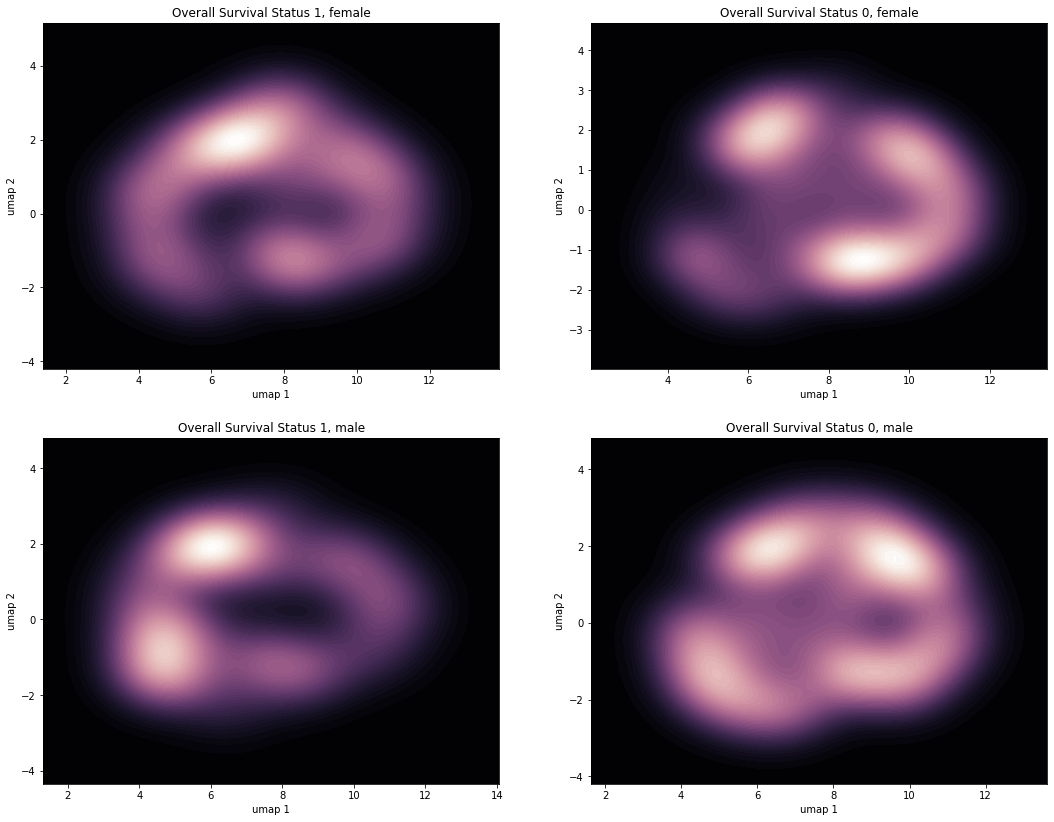

In [17]:
# short exploratory
# 1. dimension reduction
# 2. plot the differential targets

_cols = rnaID_include  # rnaID_include

tmp = Adeno
diag_str = 'Adenocarcinoma Overall Survival Status'  # 'Lung Adenocarcinoma' 'Lung Squamous Cell Carcinoma', 'Adeno/SCC'

target = 'Overall Survival Status' # 'Overall Survival Status' # Response # Gender
tmp.dropna(subset=[target], axis=0, inplace=True)

red = 'UMAP'
reduceR = UMAP(n_components=3, random_state=323, n_neighbors=50) #UMAP(n_components=3)

scaler = StandardScaler().fit(tmp.loc[:, _cols])
X = scaler.transform(tmp.loc[:, _cols])

reduceR.fit(X) #  y=tmp['Response']


fig = go.Figure(layout={'title': diag_str+' RNA expression:'+red+' components'})
# Configure the trace.
reduceD = reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==1) & (tmp['Gender']==0), _cols]))
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0], 
    y=reduceD[:,1], 
    z=reduceD[:,2], 
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name= target+' 1, Gender: male'
)
)

reduceD = reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==0) & (tmp['Gender']==0), _cols]))
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0],  
    y=reduceD[:,1],  
    z=reduceD[:,2], 
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name= target+' 0, Gender: male'
)
)

reduceD = reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==1) & (tmp['Gender']==1), _cols]))
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0], 
    y=reduceD[:,1], 
    z=reduceD[:,2], 
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name= target+' 1, Gender: female'
)
)

reduceD = reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==0) & (tmp['Gender']==1), _cols]))
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0],  
    y=reduceD[:,1],  
    z=reduceD[:,2], 
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name= target+' 0, Gender: female'
)
)


# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)
plotly.offline.iplot(fig)

##############
##############

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,14))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)


reduceR = UMAP(n_components=2, random_state=777, n_neighbors=50) #UMAP(n_components=3)
reduceR.fit(X)

reduceD = pd.DataFrame(reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==1) & (tmp['Gender']==1),
                                                               _cols])),
                   columns=['umap 1', 'umap 2'])
sns.kdeplot(reduceD['umap 1'], reduceD['umap 2'], cmap=cmap, n_levels=60, shade=True,  ax=ax[0,0])
#ax[0,0].set_xlim(4, 15)
ax[0,0].set_title(target+' 1, female')

reduceD = pd.DataFrame(reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==0) & (tmp['Gender']==1), 
                                                                  _cols])),
                       columns=['umap 1', 'umap 2'])
sns.kdeplot(reduceD['umap 1'], reduceD['umap 2'], cmap=cmap, n_levels=60, shade=True, ax=ax[0,1])
#ax[0,1].set_xlim(4, 15)
ax[0,1].set_title(target+' 0, female')

############

reduceD = pd.DataFrame(reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==1) & (tmp['Gender']==0),
                                                               _cols])),
                   columns=['umap 1', 'umap 2'])
sns.kdeplot(reduceD['umap 1'], reduceD['umap 2'], cmap=cmap, n_levels=60, shade=True,  ax=ax[1,0])
#ax[1,0].set_xlim(4, 15)
ax[1,0].set_title(target+' 1, male')

reduceD = pd.DataFrame(reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==0) & (tmp['Gender']==0), 
                                                                  _cols])),
                       columns=['umap 1', 'umap 2'])
sns.kdeplot(reduceD['umap 1'], reduceD['umap 2'], cmap=cmap, n_levels=60, shade=True, ax=ax[1,1])
#ax[1,1].set_xlim(4, 15)
ax[1,1].set_title(target+' 0, male')

In [18]:
# 4 class problem: LA/LSCC+survival/response, LA/LSCC+no survival/response
def make_target(x):
    if (x[0]=='Primary Tumor') and (x[1]==1):
        return 'deceased'
    elif (x[0]=='Primary Tumor') and (x[1]==0):
        return 'survived'   
    else:
        np.nan
        
RNAex['y'] = RNAex[['Sample Type' ,'Overall Survival Status']].apply(lambda x:
                                                                                 make_target(x), axis=1)
Xmother = RNAex.dropna(subset=['y'])
_cols = list(cols) + ['Smoking', 'Gender', 'Age At Diagnosis (Years)', 'Stage']
Xmother.dropna(subset=['Smoking', 'Gender', 'Age At Diagnosis (Years)', 'Stage'], inplace=True)
_Xmother = pd.get_dummies(Xmother[_cols], columns=['Smoking'])
_Xmother_cols = np.array(_Xmother.columns.tolist())

stat_dists_dict = dict()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Discriminating by survival status for Adenocarcinoma

In [19]:
X = _Xmother.loc[Xmother.Diagnosis=='Lung Adenocarcinoma', :].values
Y = Xmother.loc[Xmother.Diagnosis=='Lung Adenocarcinoma', 'y'].values # pd.Categorical(RNAex['y'])
Y = LabelEncoder().fit(Y).transform(Y)

In [20]:
stat_dists_dict['Adeno']= hlp.get_statdist_dataframe_binomial(X, Y, _Xmother_cols)

INFO:MainThread:numba.transforms:finding looplift candidates

Compilation is falling back to object mode WITH looplifting enabled because Function "diff_entropy_scores" failed type inference due to: Invalid use of Function(<class 'type'>) with argument(s) of type(s): (array(float64, 2d, F))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<class 'type'>)
[2] During: typing of call at /media/koekiemonster/home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py (191)


File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 191:
def diff_entropy_scores(X, eps=1e-6, bins=20):
    if "DataFrame" in str(type(X)):
    ^

INFO:MainThread:numba.transforms:finding looplift ca


Compilation is falling back to object mode WITH looplifting enabled because Function "wass1_scores" failed type inference due to: Untyped global name 'wass': cannot determine Numba type of <class 'function'>

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 570:
def wass1_scores(X,y):
    <source elided>
    for jdx in range(0, scores.shape[0]):
        scores[jdx] = wass(X[np.argwhere(y==0)[:,0], jdx], 
        ^

INFO:MainThread:numba.transforms:finding looplift candidates

Compilation is falling back to object mode WITHOUT looplifting enabled because Function "wass1_scores" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 569:
def wass1_scores(X,y):
    <source elided>
    scores = np.zeros((X.shape[1],))
    for jdx in range(0, scores.shape[0]):
    ^

Functi


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "ks_scores" failed type inference due to: Untyped global name 'ks': cannot determine Numba type of <class 'function'>

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 555:
def ks_scores(X,y):
    <source elided>
    for jdx in range(0, scores.shape[0]):
        scores[jdx,:] = ks(X[np.argwhere(y==0)[:,0], jdx], 
        ^

Function "ks_scores" was compiled in object mode without forceobj=True.

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 554:
def ks_scores(X,y):
    <source elided>
    scores = np.zeros((X.shape[1], 2))
    for jdx in range(0, scores.shape[0]):
    ^


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/refe


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "qseq_entropy_scores" failed type inference due to: Invalid use of type(CPUDispatcher(<function qseq_entropy at 0x7fed3ada82f0>)) with parameters (array(int64, 1d, C), bins=int64, q_type=unicode_type)
 * parameterized
[1] During: resolving callee type: type(CPUDispatcher(<function qseq_entropy at 0x7fed3ada82f0>))
[2] During: typing of call at /media/koekiemonster/home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py (413)


File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 413:
def qseq_entropy_scores(X, y, q_type='sum', bins=20):
    <source elided>
        y_sorted = y[np.argsort(X[:, jdx])]
        scores[jdx] = qseq_entropy(y_sorted, q_type=q_type, bins=bins)
        ^

Function "qseq_entropy_scores" was compiled in object mode without forceobj=True.

File "../../../../home/bramiozo/DEV/GIT/RexR/_hac

Function "seqX_entropy_scores" was compiled in object mode without forceobj=True.

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 473:
def seqX_entropy_scores(X, y, seqrange=(2, 20)):
    <source elided>
    seqnums = np.zeros((seqrange[1] - seqrange[0],), dtype='int64')
    for idx, seqlen in enumerate(range(seqrange[0], seqrange[1])):
    ^


Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 473:
def seqX_entropy_scores(X, y, seqrange=(2, 20)):
    <source elided>
    seqnums = np.zeros((seqrange[1] - seqrange[0],), dtype='int64')
    for idx, seqlen in enumerate(range(seqran


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_cdf" failed type inference due to: Invalid use of Function(<function append at 0x7fed94137510>) with argument(s) of type(s): (array(float64, 2d, C), list(array(float64, 1d, C)), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of Function(<function concatenate at 0x7fedac1b6158>) with argument(s) of type(s): (Tuple(array(float64, 2d, C), list(array(float64, 1d, C))), axis=Literal[int](0))
 * parameterized
In definition 0:
    TypeError: np.concatenate(): expecting a non-empty tuple of arrays, got Tuple(array(float64, 2d, C), list(array(float64, 1d, C)))
    raised from /usr/local/lib/python3.6/dist-packages/numba/typing/npydecl.py:793
In definition 1:
    TypeError: np.concatenate(): expecting a non-empty tuple of arrays, got Tuple(array(float64, 2d, C), list(array(float64, 1d, C)))
    raised from /usr

invalid value encountered in double_scalars
invalid value encountered in double_scalars
INFO:MainThread:numba.transforms:finding looplift candidates

Compilation is falling back to object mode WITH looplifting enabled because Function "q_dists" failed type inference due to: Invalid use of Function(<class 'type'>) with argument(s) of type(s): (array(float64, 2d, F))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<class 'type'>)
[2] During: typing of call at /media/koekiemonster/home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py (507)


File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 507:
def q_dists(X, y, q=0.5):
    if "DataFrame" in str(type(X)):
    


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "q_acc_scores" failed type inference due to: Invalid use of Function(<function amax at 0x7fedac0bed08>) with argument(s) of type(s): (list(float64))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function amax at 0x7fedac0bed08>)
[2] During: typing of call at /media/koekiemonster/home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py (231)


File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py", line 231:
def q_acc_scores(X,y, q=0.5):
    <source elided>
        ys = y[np.where(X[:, jdx] <= splitvalmin)]
        scores[jdx] = np.max([np.mean(yl)-cr, np.mean(ys)-cr])/cr
        ^


divide by zero encountered in log2
invalid value encountered in multiply
invalid value encountered in subtract
divide by zero encountered in log2
invalid value encountered in multiply
invalid value encountered in subtract

Compilation is falling back to object mode WITH looplifting enabled because Function "chi2_scores" failed type inference due to: Invalid use of Function(<class 'type'>) with argument(s) of type(s): (array(float64, 2d, F))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<class 'type'>)
[2] During: typing of call at /media/koekiemonster/home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py (236)


File "../../../../home/bramiozo/DEV/GIT/RexR/_hackathon2018/omic_helper_lib/omic_helpers/omic_helpers.py",

In [21]:
# filter by
if pre_filter:
    include = stat_dists_dict['Adeno'].sort_values(by='seqentropyX_wass1', ascending=False)[:select_topN].index
    X = _Xmother.loc[Xmother.Diagnosis=='Lung Adenocarcinoma', include]
    _cols = X.columns.tolist()
    
if x_transform is not None:
    X = pd.DataFrame(data=x_transform.fit_transform(X), 
                     columns=_cols, 
                     index=Xmother.loc[Xmother.Diagnosis=='Lung Adenocarcinoma'].index)

if x_reducer is not None:
    x_reducer.fit(X)
    ncomp = x_reducer.n_components_
    X = pd.DataFrame(data=x_reducer.transform(X), columns=['pc_'+str(j) for j in range(0,ncomp)], 
                     index=Xmother.loc[Xmother.Diagnosis=='Lung Adenocarcinoma'].index)
    
if rem_coll:
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
        corr = np.corrcoef(X.T) # 1 - cdist(X.T, X.T, metric='cosine')
        corr_linkage = hierarchy.ward(corr)
        dendro = hierarchy.dendrogram(corr_linkage, labels= rnamap['rnaID'].tolist(), ax=ax1,
                                      leaf_rotation=90)
        dendro_idx = np.arange(0, len(dendro['ivl']))

        ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
        ax2.set_xticks(dendro_idx)
        ax2.set_yticks(dendro_idx)
        ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
        ax2.set_yticklabels(dendro['ivl'])
        fig.tight_layout()
        plt.show()
    except Exception as e:
        print("Some problemo: ", e)
    
    
    aff_prop = AffinityPropagation(preference=-1000)
    aff_prop.fit(X.T)
    clusters = aff_prop.predict(X.T)
    exemplars = aff_prop.cluster_centers_indices_
    X = Xmother.iloc[Xmother.Diagnosis=='Lung Adenocarcinoma', exemplars]
    col_arr = np.array(rnaID_include)
    cols = col_arr[exemplars]
    
    print('Number of exemplars:', len(cols))
    clust_list = defaultdict(list)
    for idx, _exemplar_id in enumerate(aff_prop.cluster_centers_indices_):
        _exemplar_column = col_arr[_exemplar_id]
        for jdx, _idx in enumerate(aff_prop.labels_):
            if idx == _idx: 
                clust_list[_exemplar_column].append(col_arr[jdx])
            
else:
    col_arr = X.columns.tolist()
    cols= col_arr

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    random_state=123, stratify=Y, train_size=0.90)

In [23]:
models = {'RF': RF(n_estimators=500), 
          'XGB': xgb(n_estimators=500), 
          'HB': HB(max_bins=200),
          'ET': ET(n_estimators=1000),
          'LGBM': lgbm(n_estimators=500),
          'LR': LR(penalty='elasticnet', solver='saga', l1_ratio=0.4),
          'SVM': SVC(C=0.9)}
############################################
print('Fitting RF')
models['RF'].fit(X_train, y_train)
print('Fitting XGB')
models['XGB'].fit(X_train, y_train)
print('Fitting HB')
models['HB'].fit(X_train, y_train)
print('Fitting ET')
models['ET'].fit(X_train, y_train)
print('Fitting LGBM')
models['LGBM'].fit(X_train, y_train)
print('Fitting LR')
models['LR'].fit(X_train, y_train)
print('Fitting SVM')
models['SVM'].fit(X_train, y_train)


############################################
perm_result = dict()
print("Getting permutation scores for RF")
perm_result['RF'] = permutation_importance(models['RF'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for XGB")
perm_result['XGB'] = permutation_importance(models['XGB'], X_test, y_test, 
                                            n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for HB")
perm_result['HB'] = permutation_importance(models['HB'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for ET")
perm_result['ET'] = permutation_importance(models['ET'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LGBM")
perm_result['LGBM'] = permutation_importance(models['LGBM'], X_test, y_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LR")
perm_result['LR'] = permutation_importance(models['LR'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for SVM")
perm_result['SVM'] = permutation_importance(models['SVM'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)
gc.collect()



Fitting RF
Fitting XGB
Fitting HB
Fitting ET
Fitting LGBM
Fitting LR
Fitting SVM
Getting permutation scores for RF


The max_iter was reached which means the coef_ did not converge


Getting permutation scores for XGB
Getting permutation scores for HB
Getting permutation scores for ET


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Getting permutation scores for LGBM
Getting permutation scores for LR
Getting permutation scores for SVM


2302

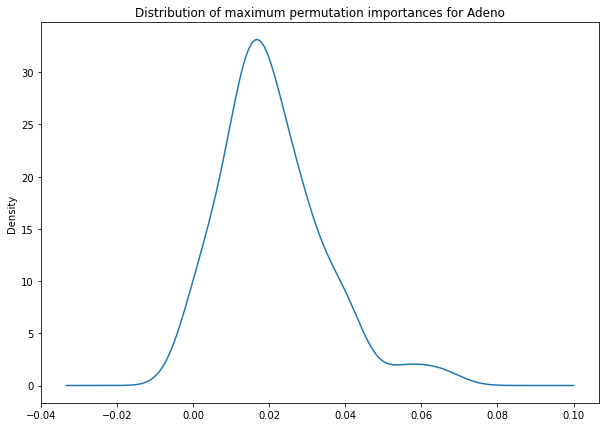

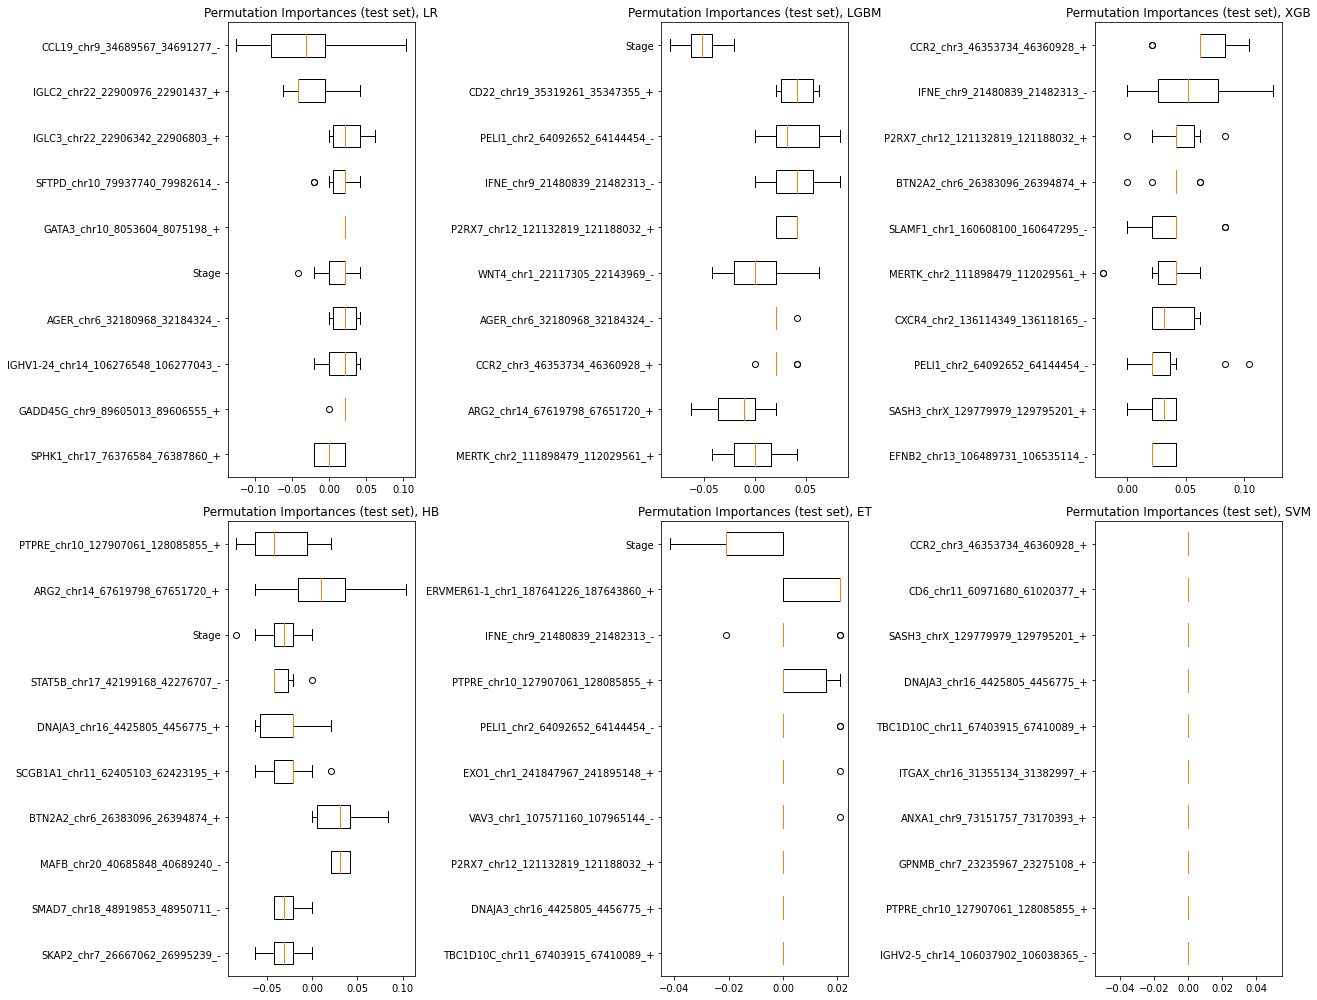

In [24]:
############################################
tmp_imp = np.vstack([np.abs(perm_result['RF'].importances).mean(axis=1),
           np.abs(perm_result['XGB'].importances).mean(axis=1),
           np.abs(perm_result['HB'].importances).mean(axis=1),
           np.abs(perm_result['ET'].importances).mean(axis=1),      
           np.abs(perm_result['LGBM'].importances).mean(axis=1),
           np.abs(perm_result['LR'].importances).mean(axis=1),
           np.abs(perm_result['SVM'].importances).mean(axis=1)]).transpose()
perm_df = pd.DataFrame(data=tmp_imp, index=_cols, columns=['RF', 'XGB', 'HB', 'ET', 'LGBM', 'LR', 'SVM'])

perm_df.max(axis=1).plot.kde(figsize=(10, 7))
plt.title("Distribution of maximum permutation importances for Adeno")

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18,14))


sorted_idx = np.abs(perm_result['LR'].importances).mean(axis=1).argsort()[-10:]
ax[0,0].boxplot(perm_result['LR'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[0,0].set_title("Permutation Importances (test set), LR")

sorted_idx = np.abs(perm_result['LGBM'].importances).mean(axis=1).argsort()[-10:]
ax[0,1].boxplot(perm_result['LGBM'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[0,1].set_title("Permutation Importances (test set), LGBM")


sorted_idx = np.abs(perm_result['XGB'].importances).mean(axis=1).argsort()[-10:]
ax[0,2].boxplot(perm_result['XGB'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[0,2].set_title("Permutation Importances (test set), XGB")
################
################
sorted_idx = np.abs(perm_result['HB'].importances).mean(axis=1).argsort()[-10:]
ax[1,0].boxplot(perm_result['HB'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[1,0].set_title("Permutation Importances (test set), HB")

sorted_idx = np.abs(perm_result['ET'].importances).mean(axis=1).argsort()[-10:]
ax[1,1].boxplot(perm_result['ET'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[1,1].set_title("Permutation Importances (test set), ET")


sorted_idx = np.abs(perm_result['SVM'].importances).mean(axis=1).argsort()[-10:]
ax[1,2].boxplot(perm_result['SVM'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[1,2].set_title("Permutation Importances (test set), SVM")


fig.tight_layout()
plt.show()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.


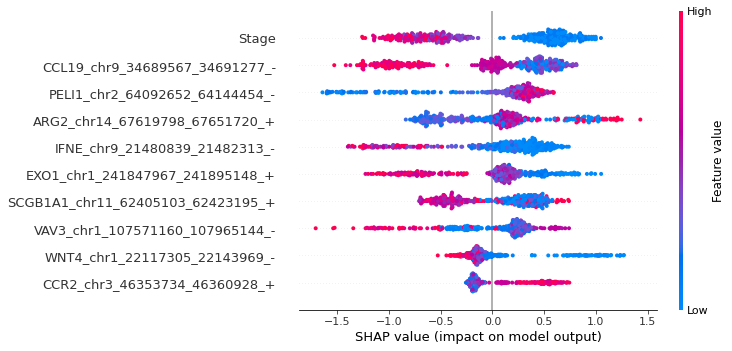

Make kernel explainer..
Get SHAP values..
Get summary of results


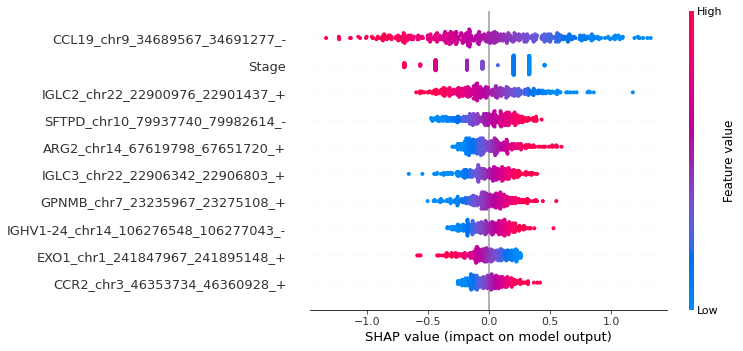

In [25]:
##############
##############
from shap import sample as shap_sample
from shap import kmeans as shap_kmeans

#fig, ax = plt.subplots(nrows=6, figsize=(14,20))

explainer = TreeExplainer(models['XGB'])
shap_values = explainer.shap_values(X_train)
summary_plot(shap_values, X_train, max_display=10)

print("Make kernel explainer..")
explainer = LinearExplainer(models['LR'], X_train)
print("Get SHAP values..")
shap_values = explainer.shap_values(X_train)
print("Get summary of results")
summary_plot(shap_values, X_train, max_display=10)

#print("Make kernel explainer..")
#explainer = KernelExplainer(models['SVM'].predict, X)
#print("Get SHAP values..")
#shap_values = explainer.shap_values(shap_sample(X, 5))
#print("Get summary of results")
#summary_plot(shap_values, X_test, max_display=10, plot_type='dots')

##############
##############

In [26]:
for _m in models.keys():
    y_pred = models[_m].predict(X_test)
    print("Model:{}, balanced accuracy:{}".format(_m, balanced_accuracy_score(y_test, y_pred)))
    

Model:RF, balanced accuracy:0.5398481973434535
Model:XGB, balanced accuracy:0.6413662239089184
Model:HB, balanced accuracy:0.5958254269449715
Model:ET, balanced accuracy:0.555977229601518
Model:LGBM, balanced accuracy:0.611954459203036
Model:LR, balanced accuracy:0.5370018975332068
Model:SVM, balanced accuracy:0.5


### Discriminating by survival status for Squamous Cell Carcinoma

In [27]:
X = _Xmother.loc[Xmother.Diagnosis=='Lung Squamous Cell Carcinoma', :].values
Y = Xmother.loc[Xmother.Diagnosis=='Lung Squamous Cell Carcinoma', 'y'].values # pd.Categorical(RNAex['y'])
Y = LabelEncoder().fit(Y).transform(Y)


stat_dists_dict['SCC']= hlp.get_statdist_dataframe_binomial(X, Y, _Xmother_cols)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
divide by zero encountered in log2
invalid value encountered in multiply
invalid value encountered in subtract
divide by zero encountered in log2
invalid value encountered in multiply
invalid value encountered in subtract
divide by zero encountered in log2
invalid value encountered in multiply
invalid value encountered in subtract
invalid value encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in multiply
invalid value encountered in cos
invalid value encountered in sin
invalid value encountered in multiply
invalid value encountered in cos
invalid value encountered in sin
Estimated covariance matrix does not have full rank. This indicates a bad choice of the input t and the test might not be consistent.


In [28]:
# filter by
if pre_filter:
    include = stat_dists_dict['SCC'].sort_values(by='seqentropyX_wass1', ascending=False)[:select_topN].index
    X = _Xmother.loc[Xmother.Diagnosis=='Lung Squamous Cell Carcinoma', include]
    _cols = X.columns.tolist()
    
if x_transform is not None:
    X = pd.DataFrame(data=x_transform.fit_transform(X), 
                     columns=_cols, 
                     index=Xmother.loc[Xmother.Diagnosis=='Lung Squamous Cell Carcinoma'].index)

if x_reducer is not None:
    x_reducer.fit(X)
    ncomp = x_reducer.n_components_
    X = pd.DataFrame(data=x_reducer.transform(X), columns=['pc_'+str(j) for j in range(0,ncomp)], 
                     index=Xmother.loc[Xmother.Diagnosis=='Lung Squamous Cell Carcinoma'].index)
    
if rem_coll:
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
        corr = np.corrcoef(X.T) # 1 - cdist(X.T, X.T, metric='cosine')
        corr_linkage = hierarchy.ward(corr)
        dendro = hierarchy.dendrogram(corr_linkage, labels= rnamap['rnaID'].tolist(), ax=ax1,
                                      leaf_rotation=90)
        dendro_idx = np.arange(0, len(dendro['ivl']))

        ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
        ax2.set_xticks(dendro_idx)
        ax2.set_yticks(dendro_idx)
        ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
        ax2.set_yticklabels(dendro['ivl'])
        fig.tight_layout()
        plt.show()
    except Exception as e:
        print("Some problemo: ", e)
    
    
    aff_prop = AffinityPropagation(preference=-1000)
    aff_prop.fit(X.T)
    clusters = aff_prop.predict(X.T)
    exemplars = aff_prop.cluster_centers_indices_
    X = Xmother.iloc[Xmother.Diagnosis=='Lung Squamous Cell Carcinoma', exemplars]
    col_arr = np.array(rnaID_include)
    cols = col_arr[exemplars]
    
    print('Number of exemplars:', len(cols))
    clust_list = defaultdict(list)
    for idx, _exemplar_id in enumerate(aff_prop.cluster_centers_indices_):
        _exemplar_column = col_arr[_exemplar_id]
        for jdx, _idx in enumerate(aff_prop.labels_):
            if idx == _idx: 
                clust_list[_exemplar_column].append(col_arr[jdx])
            
else:
    col_arr = X.columns.tolist()
    cols= col_arr

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    random_state=123, stratify=Y, train_size=0.90)

Fitting RF
Fitting XGB
Fitting HB
Fitting ET
Fitting LGBM
Fitting LR
Fitting SVM
Getting permutation scores for RF


The max_iter was reached which means the coef_ did not converge


Getting permutation scores for XGB
Getting permutation scores for HB
Getting permutation scores for ET
Getting permutation scores for LGBM
Getting permutation scores for LR
Getting permutation scores for SVM


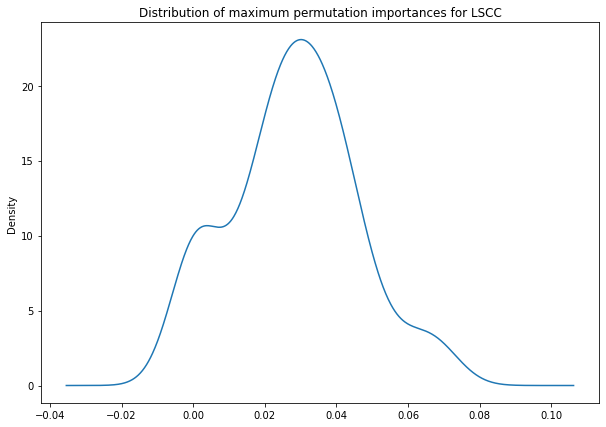

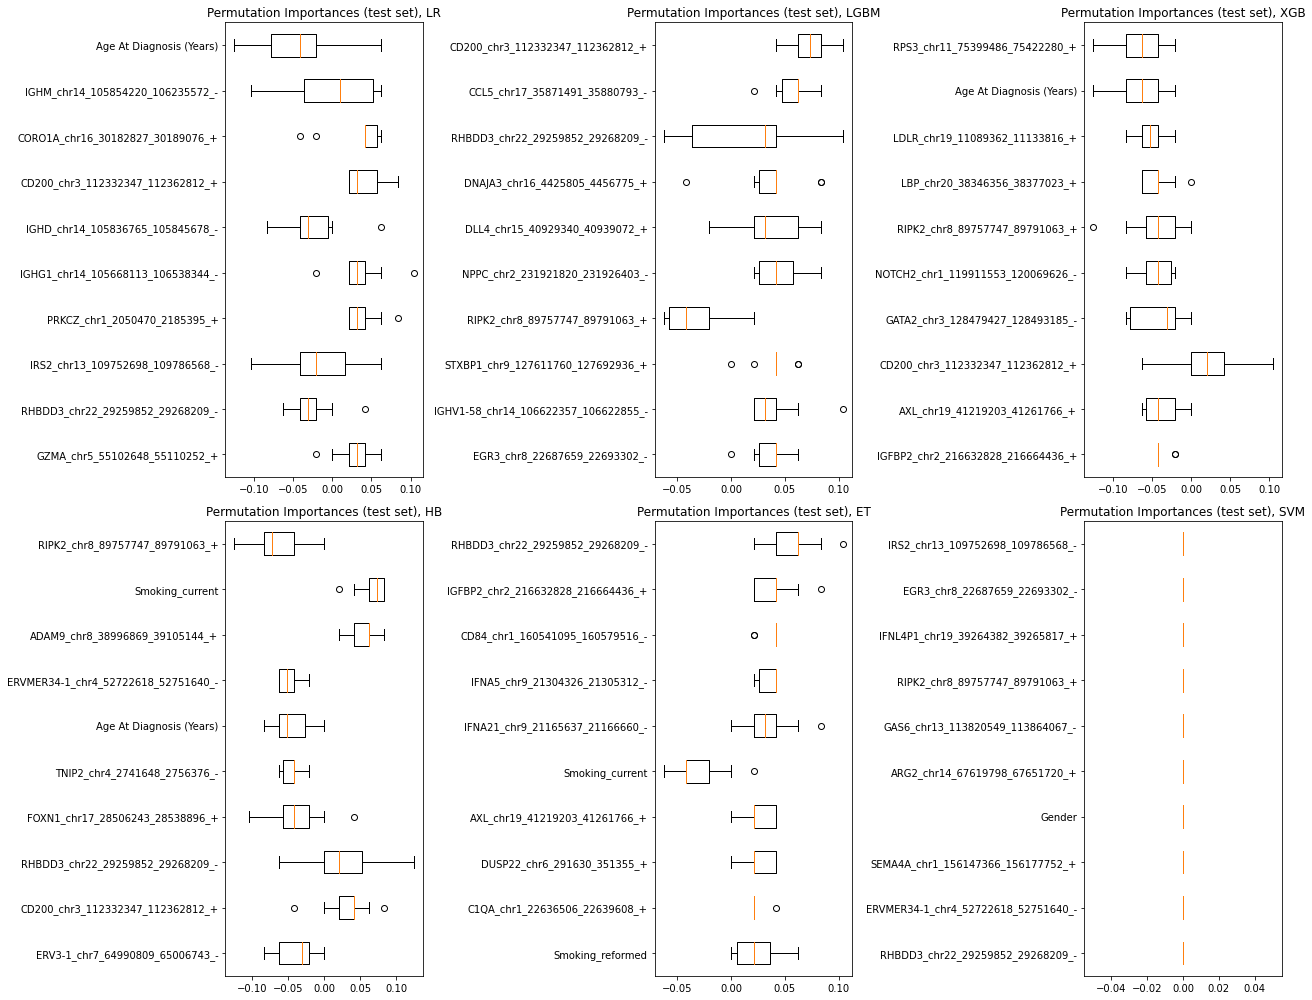

In [30]:
models = {'RF': RF(n_estimators=500), 
          'XGB': xgb(n_estimators=500), 
          'HB': HB(max_bins=200),
          'ET': ET(n_estimators=1000),
          'LGBM': lgbm(n_estimators=500),
          'LR': LR(penalty='elasticnet', solver='saga', l1_ratio=0.5),
          'SVM': SVC(C=0.8)}
############################################
print('Fitting RF')
models['RF'].fit(X_train, y_train)
print('Fitting XGB')
models['XGB'].fit(X_train, y_train)
print('Fitting HB')
models['HB'].fit(X_train, y_train)
print('Fitting ET')
models['ET'].fit(X_train, y_train)
print('Fitting LGBM')
models['LGBM'].fit(X_train, y_train)
print('Fitting LR')
models['LR'].fit(X_train, y_train)
print('Fitting SVM')
models['SVM'].fit(X_train, y_train)


############################################
perm_result = dict()
print("Getting permutation scores for RF")
perm_result['RF'] = permutation_importance(models['RF'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for XGB")
perm_result['XGB'] = permutation_importance(models['XGB'], X_test, y_test, 
                                            n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for HB")
perm_result['HB'] = permutation_importance(models['HB'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for ET")
perm_result['ET'] = permutation_importance(models['ET'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LGBM")
perm_result['LGBM'] = permutation_importance(models['LGBM'], X_test, y_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LR")
perm_result['LR'] = permutation_importance(models['LR'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for SVM")
perm_result['SVM'] = permutation_importance(models['SVM'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)
gc.collect()

############################################
tmp_imp = np.vstack([np.abs(perm_result['RF'].importances).mean(axis=1),
           np.abs(perm_result['XGB'].importances).mean(axis=1),
           np.abs(perm_result['HB'].importances).mean(axis=1),
           np.abs(perm_result['ET'].importances).mean(axis=1),      
           np.abs(perm_result['LGBM'].importances).mean(axis=1),
           np.abs(perm_result['LR'].importances).mean(axis=1),
           np.abs(perm_result['SVM'].importances).mean(axis=1)]).transpose()
perm_df = pd.DataFrame(data=tmp_imp, index=_cols, columns=['RF', 'XGB', 'HB', 'ET', 'LGBM', 'LR', 'SVM'])

perm_df.max(axis=1).plot.kde(figsize=(10, 7))
plt.title("Distribution of maximum permutation importances for LSCC")

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18,14))


sorted_idx = np.abs(perm_result['LR'].importances).mean(axis=1).argsort()[-10:]
ax[0,0].boxplot(perm_result['LR'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[0,0].set_title("Permutation Importances (test set), LR")

sorted_idx = np.abs(perm_result['LGBM'].importances).mean(axis=1).argsort()[-10:]
ax[0,1].boxplot(perm_result['LGBM'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[0,1].set_title("Permutation Importances (test set), LGBM")


sorted_idx = np.abs(perm_result['XGB'].importances).mean(axis=1).argsort()[-10:]
ax[0,2].boxplot(perm_result['XGB'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[0,2].set_title("Permutation Importances (test set), XGB")
################
################
sorted_idx = np.abs(perm_result['HB'].importances).mean(axis=1).argsort()[-10:]
ax[1,0].boxplot(perm_result['HB'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[1,0].set_title("Permutation Importances (test set), HB")

sorted_idx = np.abs(perm_result['ET'].importances).mean(axis=1).argsort()[-10:]
ax[1,1].boxplot(perm_result['ET'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[1,1].set_title("Permutation Importances (test set), ET")


sorted_idx = np.abs(perm_result['SVM'].importances).mean(axis=1).argsort()[-10:]
ax[1,2].boxplot(perm_result['SVM'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[1,2].set_title("Permutation Importances (test set), SVM")


fig.tight_layout()
plt.show()


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


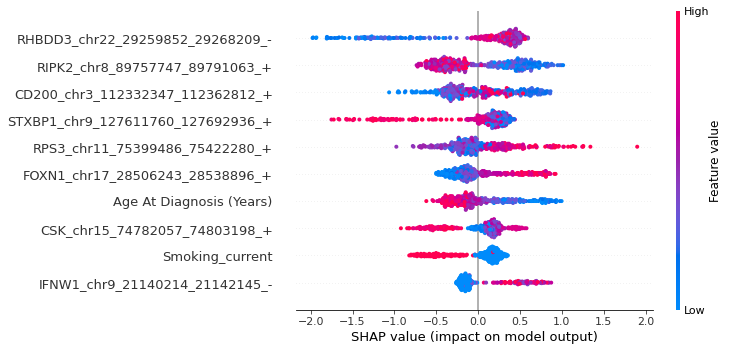

Make linear explainer..
Get SHAP values..
Get summary of results


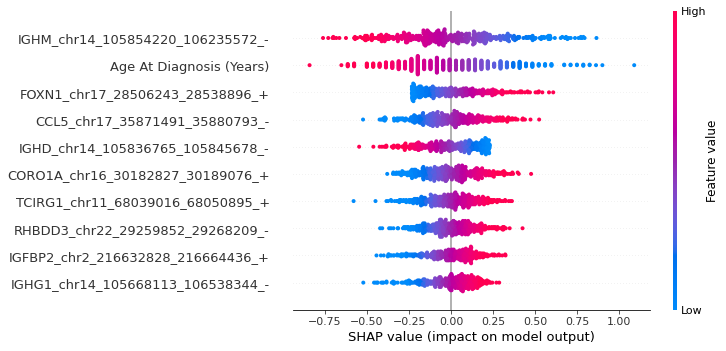

Model:RF, Accuracy:0.5476190476190476
Model:XGB, Accuracy:0.5105820105820106
Model:HB, Accuracy:0.5291005291005291
Model:ET, Accuracy:0.5555555555555556
Model:LGBM, Accuracy:0.5793650793650793
Model:LR, Accuracy:0.6084656084656084
Model:SVM, Accuracy:0.5


In [31]:
##############
##############

explainer = TreeExplainer(models['XGB'])
shap_values = explainer.shap_values(X_train)
summary_plot(shap_values, X_train, max_display=10)


print("Make linear explainer..")
explainer = LinearExplainer(models['LR'], X_train)
print("Get SHAP values..")
shap_values = explainer.shap_values(X_train)
print("Get summary of results")
summary_plot(shap_values, X_train, max_display=10)


for _m in models.keys():
    y_pred = models[_m].predict(X_test)
    print("Model:{}, Accuracy:{}".format(_m, balanced_accuracy_score(y_test, y_pred)))

### Discriminating for survival status on both sets together

In [32]:
X = _Xmother.values
X = StandardScaler().fit_transform(X)
Y= Xmother.loc[:, 'y'].values # pd.Categorical(RNAex['y'])
Y = LabelEncoder().fit(Y).transform(Y)

In [33]:
stat_dists_dict['ALL']= hlp.get_statdist_dataframe_binomial(X, Y, _Xmother_cols)

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
Mean of empty slice.
invalid value encountered in double_scalars
divide by zero encountered in log2
invalid value encountered in multiply
invalid value encountered in subtract
divide by zero encountered in log2
invalid value encountered in multiply
invalid value encountered in subtract
divide by zero encountered in log2
invalid value encountered in multiply
invalid value encountered in subtract
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in cos
invalid value encountered in sin
invalid value encountered in cos
invalid value encountered in sin
Estimated covariance matrix does not have full rank. This indicates a bad choice of the input t and the test might not be consistent.


In [34]:
# filter by
if pre_filter:
    include = stat_dists_dict['ALL'].sort_values(by='seqentropyX_wass1', ascending=False)[:select_topN].index
    X = _Xmother.loc[:, include]
    _cols = X.columns.tolist()
    
if x_transform is not None:
    X = pd.DataFrame(data=x_transform.fit_transform(X), 
                     columns=_cols, 
                     index=Xmother.index)

if x_reducer is not None:
    x_reducer.fit(X)
    ncomp = x_reducer.n_components_
    X = pd.DataFrame(data=x_reducer.transform(X), columns=['pc_'+str(j) for j in range(0,ncomp)], 
                     index=Xmother.index)
    
if rem_coll:
    try:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
        corr = np.corrcoef(X.T) # 1 - cdist(X.T, X.T, metric='cosine')
        corr_linkage = hierarchy.ward(corr)
        dendro = hierarchy.dendrogram(corr_linkage, labels= rnamap['rnaID'].tolist(), ax=ax1,
                                      leaf_rotation=90)
        dendro_idx = np.arange(0, len(dendro['ivl']))

        ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
        ax2.set_xticks(dendro_idx)
        ax2.set_yticks(dendro_idx)
        ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
        ax2.set_yticklabels(dendro['ivl'])
        fig.tight_layout()
        plt.show()
    except Exception as e:
        print("Some problemo: ", e)
    
    
    aff_prop = AffinityPropagation(preference=-1000)
    aff_prop.fit(X.T)
    clusters = aff_prop.predict(X.T)
    exemplars = aff_prop.cluster_centers_indices_
    X = Xmother.iloc[:, exemplars]
    col_arr = np.array(rnaID_include)
    cols = col_arr[exemplars]
    
    print('Number of exemplars:', len(cols))
    clust_list = defaultdict(list)
    for idx, _exemplar_id in enumerate(aff_prop.cluster_centers_indices_):
        _exemplar_column = col_arr[_exemplar_id]
        for jdx, _idx in enumerate(aff_prop.labels_):
            if idx == _idx: 
                clust_list[_exemplar_column].append(col_arr[jdx])
            
else:
    col_arr = X.columns.tolist()
    cols= col_arr

Fitting RF
Fitting XGB
Fitting HB
Fitting ET
Fitting LGBM
Fitting LR
Fitting SVM


The max_iter was reached which means the coef_ did not converge


Getting permutation scores for RF
Getting permutation scores for XGB
Getting permutation scores for HB
Getting permutation scores for ET


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Getting permutation scores for LGBM
Getting permutation scores for LR
Getting permutation scores for SVM


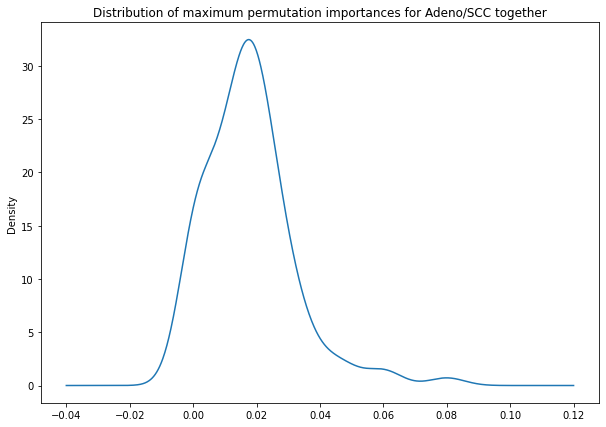

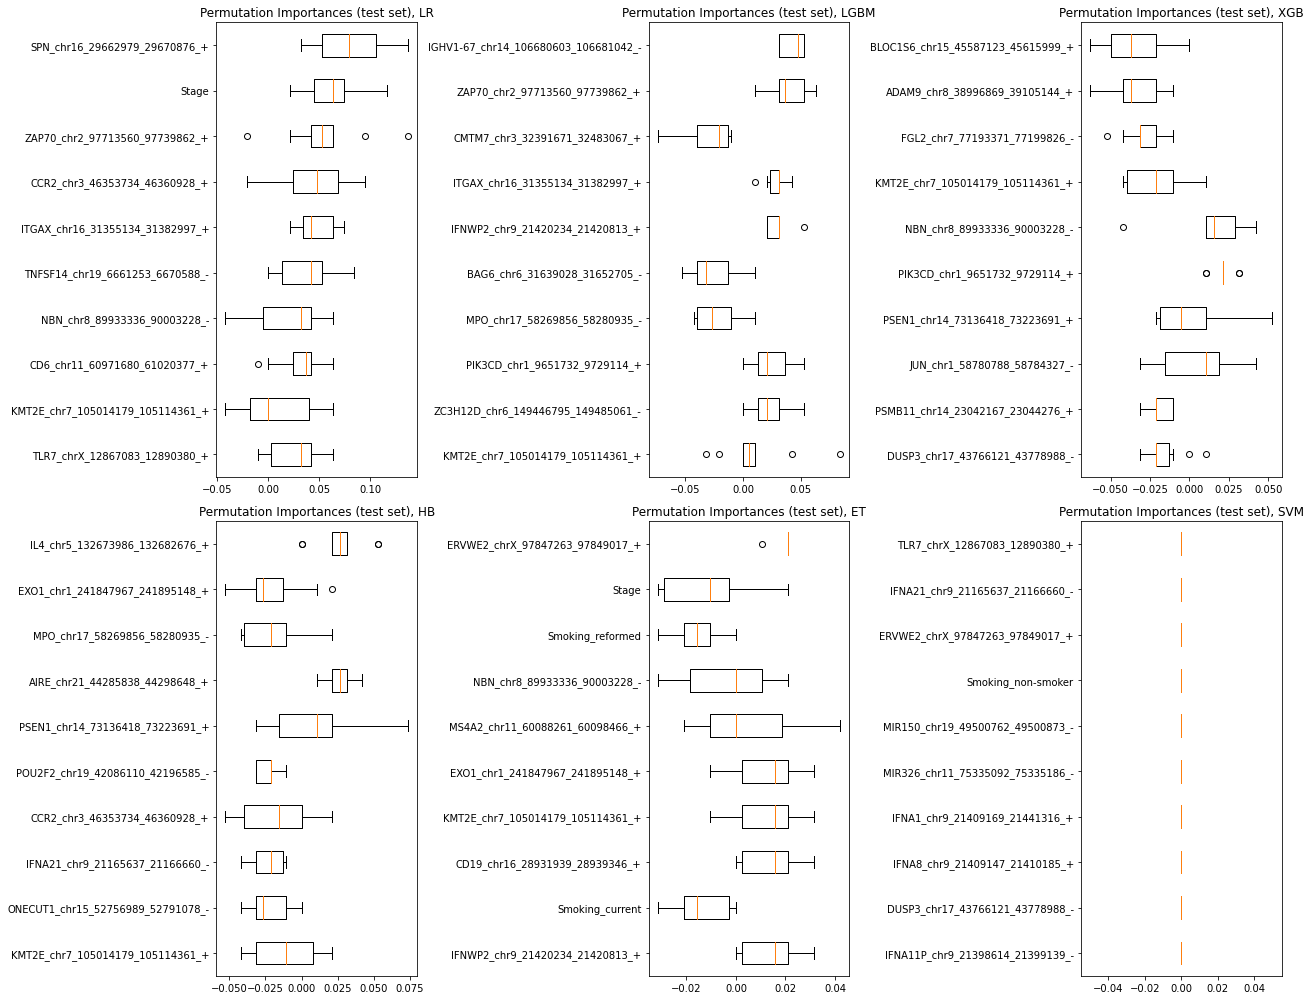

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    random_state=123, stratify=Y, train_size=0.90)

models = {'RF': RF(n_estimators=500), 
          'XGB': xgb(n_estimators=500), 
          'HB': HB(max_bins=200),
          'ET': ET(n_estimators=1000),
          'LGBM': lgbm(n_estimators=500),
          'LR': LR(penalty='elasticnet', solver='saga', l1_ratio=0.5),
          'SVM': SVC(C=0.8)}
############################################
print('Fitting RF')
models['RF'].fit(X_train, y_train)
print('Fitting XGB')
models['XGB'].fit(X_train, y_train)
print('Fitting HB')
models['HB'].fit(X_train, y_train)
print('Fitting ET')
models['ET'].fit(X_train, y_train)
print('Fitting LGBM')
models['LGBM'].fit(X_train, y_train)
print('Fitting LR')
models['LR'].fit(X_train, y_train)
print('Fitting SVM')
models['SVM'].fit(X_train, y_train)


############################################
perm_result = dict()
print("Getting permutation scores for RF")
perm_result['RF'] = permutation_importance(models['RF'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for XGB")
perm_result['XGB'] = permutation_importance(models['XGB'], X_test, y_test, 
                                            n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for HB")
perm_result['HB'] = permutation_importance(models['HB'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for ET")
perm_result['ET'] = permutation_importance(models['ET'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LGBM")
perm_result['LGBM'] = permutation_importance(models['LGBM'], X_test, y_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LR")
perm_result['LR'] = permutation_importance(models['LR'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for SVM")
perm_result['SVM'] = permutation_importance(models['SVM'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)
gc.collect()

############################################
tmp_imp = np.vstack([np.abs(perm_result['RF'].importances).mean(axis=1),
           np.abs(perm_result['XGB'].importances).mean(axis=1),
           np.abs(perm_result['HB'].importances).mean(axis=1),
           np.abs(perm_result['ET'].importances).mean(axis=1),      
           np.abs(perm_result['LGBM'].importances).mean(axis=1),
           np.abs(perm_result['LR'].importances).mean(axis=1),
           np.abs(perm_result['SVM'].importances).mean(axis=1)]).transpose()
perm_df = pd.DataFrame(data=tmp_imp, index=_cols, columns=['RF', 'XGB', 'HB', 'ET', 'LGBM', 'LR', 'SVM'])

perm_df.max(axis=1).plot.kde(figsize=(10, 7))
plt.title("Distribution of maximum permutation importances for Adeno/SCC together")


fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18,14))
sorted_idx = np.abs(perm_result['LR'].importances).mean(axis=1).argsort()[-10:]
ax[0,0].boxplot(perm_result['LR'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[0,0].set_title("Permutation Importances (test set), LR")

sorted_idx = np.abs(perm_result['LGBM'].importances).mean(axis=1).argsort()[-10:]
ax[0,1].boxplot(perm_result['LGBM'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[0,1].set_title("Permutation Importances (test set), LGBM")


sorted_idx = np.abs(perm_result['XGB'].importances).mean(axis=1).argsort()[-10:]
ax[0,2].boxplot(perm_result['XGB'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[0,2].set_title("Permutation Importances (test set), XGB")
################
################
sorted_idx = np.abs(perm_result['HB'].importances).mean(axis=1).argsort()[-10:]
ax[1,0].boxplot(perm_result['HB'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[1,0].set_title("Permutation Importances (test set), HB")

sorted_idx = np.abs(perm_result['ET'].importances).mean(axis=1).argsort()[-10:]
ax[1,1].boxplot(perm_result['ET'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[1,1].set_title("Permutation Importances (test set), ET")


sorted_idx = np.abs(perm_result['SVM'].importances).mean(axis=1).argsort()[-10:]
ax[1,2].boxplot(perm_result['SVM'].importances[sorted_idx].T,
           vert=False, labels=np.array(_cols)[sorted_idx])
ax[1,2].set_title("Permutation Importances (test set), SVM")


fig.tight_layout()
plt.show()


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


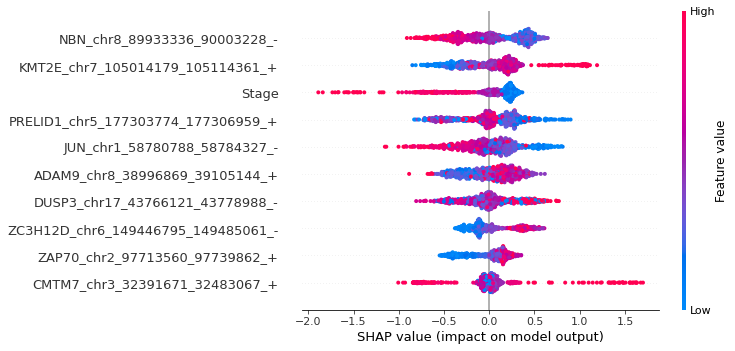

Make linear explainer..
Get SHAP values..
Get summary of results


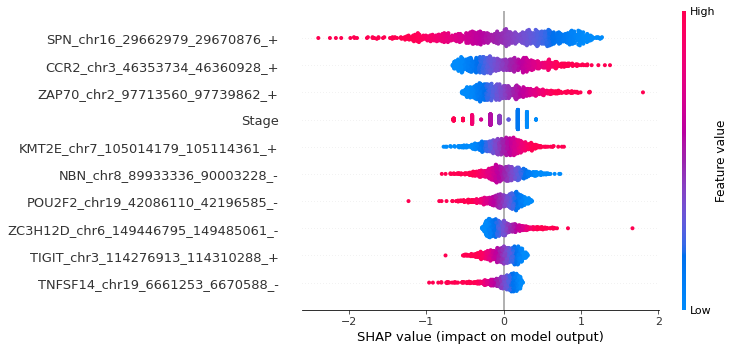

Model:RF, Accuracy:0.5745614035087719
Model:XGB, Accuracy:0.5219298245614035
Model:HB, Accuracy:0.5
Model:ET, Accuracy:0.5745614035087719
Model:LGBM, Accuracy:0.5657894736842105
Model:LR, Accuracy:0.6535087719298245
Model:SVM, Accuracy:0.5


In [36]:
##############
##############

explainer = TreeExplainer(models['XGB'])
shap_values = explainer.shap_values(X_train)
summary_plot(shap_values, X_train, max_display=10)


print("Make linear explainer..")
explainer = LinearExplainer(models['LR'], X_train)
print("Get SHAP values..")
shap_values = explainer.shap_values(X_train)
print("Get summary of results")
summary_plot(shap_values, X_train, max_display=10)


for _m in models.keys():
    y_pred = models[_m].predict(X_test)
    print("Model:{}, Accuracy:{}".format(_m, balanced_accuracy_score(y_test, y_pred)))